# Assignment 2: Bike Rental Prediction

In [56]:
# GitHub link to repo: https://github.com/dianacord/ML-fundamentals-2025

## Task 1: Exploratory Data Analysis (EDA)

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("hour.csv")

# Quick overview
print(df.shape)
df.head()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


The output from this first cell just confirms what you mentioned in the assignment document. The dataset has 17379 records and the 17 variables shown as the columns.

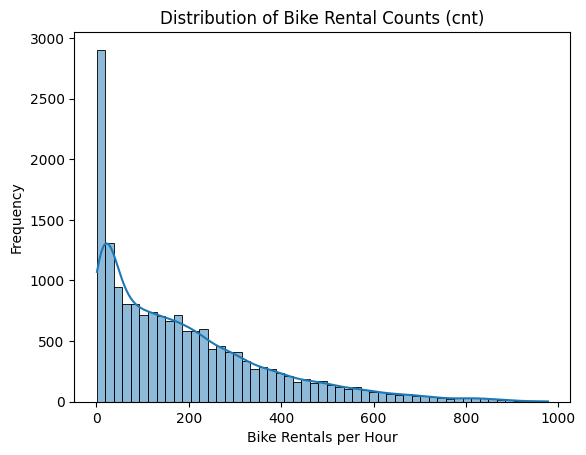

1.2774116037490577

In [58]:
# Target distribution
sns.histplot(df['cnt'], kde=True)
plt.title('Distribution of Bike Rental Counts (cnt)')
plt.xlabel('Bike Rentals per Hour')
plt.ylabel('Frequency')
plt.show()

# Skewness
df['cnt'].skew()

Here we are examing the target variable `cnt` by plotting its distribution. Why? This tells us whether or not we're gonna have to transform or normalize the target later for certain models that assume normality, for example linear regression (we will later do it for this model). By interpreting the plot, we deduce that the `cnt` distribution has a very strong right skew, which is also confirmed by the printed value of approximately 1.28. This is the skew value, and if it's between 1 and 1.5 it means it has a highly skewed distribution. Given that the frequency is how many hours had that many rentals, that big spike on the left tells us that there's a lot of hours where only a few bikes were rented. In other words most of the time rental counts are low, and only occasionally we see high demand. 

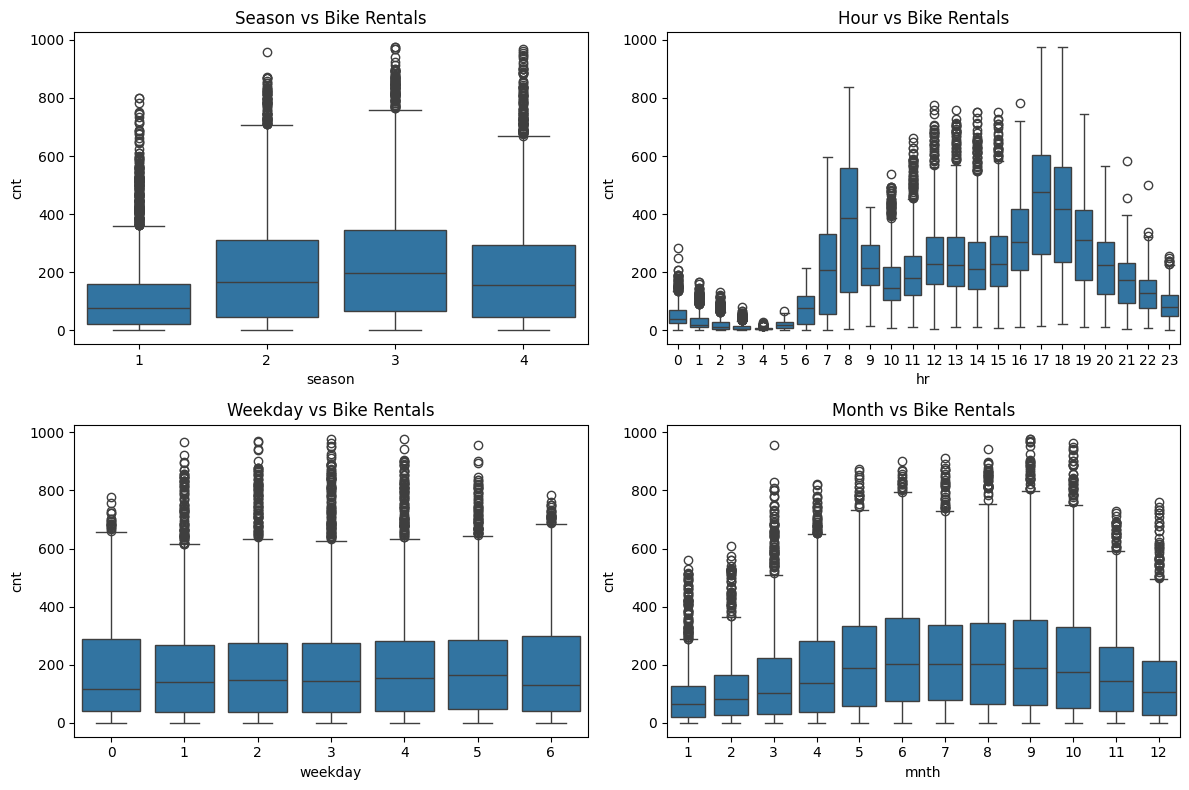

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.boxplot(x='season', y='cnt', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Season vs Bike Rentals')

sns.boxplot(x='hr', y='cnt', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Hour vs Bike Rentals')

sns.boxplot(x='weekday', y='cnt', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Weekday vs Bike Rentals')

sns.boxplot(x='mnth', y='cnt', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Month vs Bike Rentals')

plt.tight_layout()
plt.show()

### Temporal variables insights

First thing I noticed is the Hour vs Bike Rentals plot. `hr` is definetely one of if not the most influential predictor of the temporal variable.There are clear peaks at 8am and 5-6 pm, probabaly because of commuters. There's a wide spread during said peak times indicating that there is a hig variance in demand. There are also very few rentals late at night and very early in the morning. 

From the `season` plot we can gather:
- On average, rentals increase in spring (2) and summer(3) and decrease in fall(4) and winter (1). 
- We have consistent outliers meaning there are busy rental days even in winter and fall.

I would say `season` has a moderate predicative impact on bike rentals. Not as string as `hr` but we can still see a seasonal variation in demand.

The Month vs Bike Rentals plot also has large variability within each month. I'm also lead to believe that `mnth` and `season` might be correlated to because we can see that months in the same season behave similarly. This tell me that I'll have to test for multicollinearity later, or I could also test dropping one of them.

Lastly, Weekday vs Bike rentals is flat accross all weekdays. There is a slight dip on Monday(1) but nothing major. There is a high number of outliers every day though. To conclude, I think `weekday` has weak predicative impact on its own, so unless it shows interaction effects with other variables, I might drop it during feature selection.

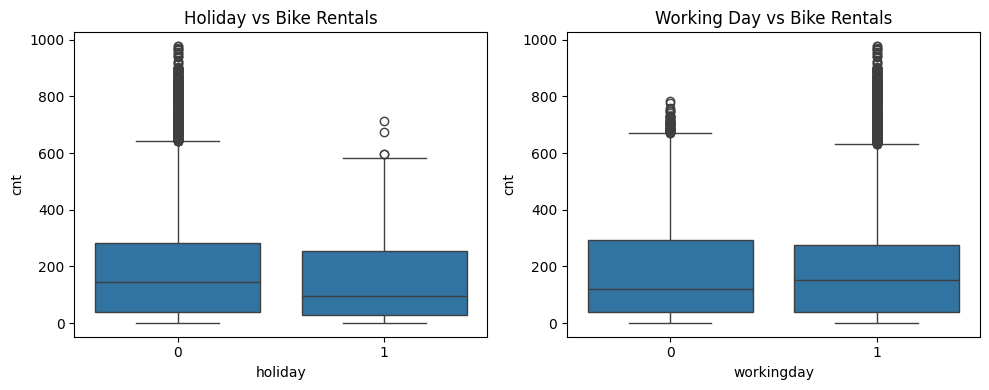

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(x='holiday', y='cnt', data=df, ax=axes[0])
axes[0].set_title('Holiday vs Bike Rentals')

sns.boxplot(x='workingday', y='cnt', data=df, ax=axes[1])
axes[1].set_title('Working Day vs Bike Rentals')

plt.tight_layout()
plt.show()

### Binary variables insights

In the Holiday vs Bike Rentals plot we can say:
- Median on rentals are lower on holidays(1) than on non-holidays(0).
- There are few extreme outliers on holidays.
- Distribution is more compact for holidays.

In conclusion, holidays reduce demand, but the effect of this variable is low, and might not be essential for some models.

Moving on to Working Day vs Bike Rental plot:
- Slightly higher median rentals on working days(1).
- Distributions are too similar accross both.

From this we can deduce working day status shows only a small influence on rental behavior.

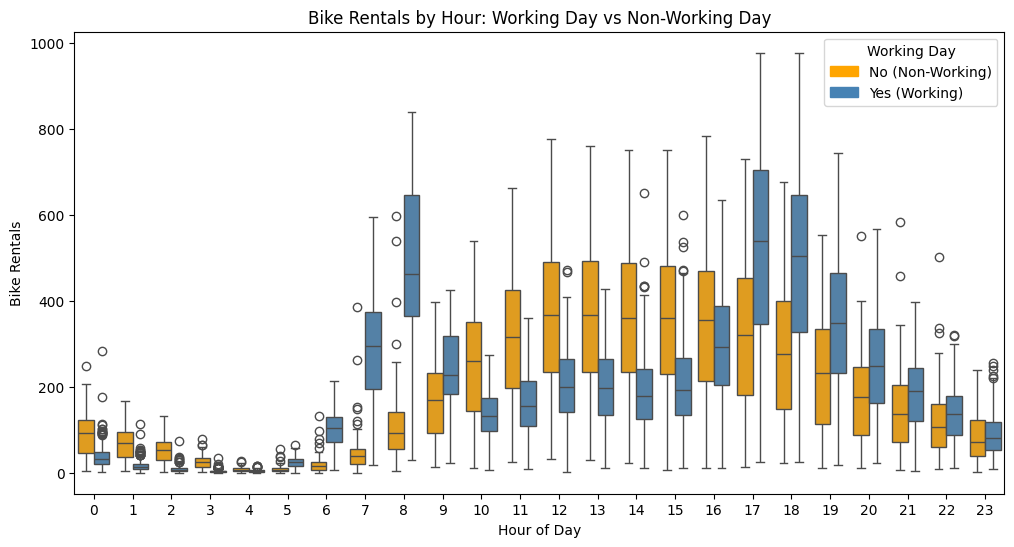

In [61]:
from matplotlib.patches import Patch
plt.figure(figsize=(12, 6))

palette = {0: "orange", 1: "steelblue"}

sns.boxplot(x='hr', y='cnt', hue='workingday', data=df, palette=palette)

plt.title('Bike Rentals by Hour: Working Day vs Non-Working Day')
plt.xlabel('Hour of Day')
plt.ylabel('Bike Rentals')
legend_handles = [
    Patch(color=palette[0], label='No (Non-Working)'),
    Patch(color=palette[1], label='Yes (Working)')
]
plt.legend(handles=legend_handles, title='Working Day', loc='upper right')

plt.show()

I decided to plot the combination of `hr` and `workingday`, which reveals a clear interaction effect. On working days, bike rentals spike around commuting hours, while on non-working days, demand is more spread out during the daytime. This tell us that the predictive power of `hr` is conditional on `workingday`. It suggests that we could potentially engineer an interaction feature for the linear model, however tree-based models naturally notice these dependencies on their own. 

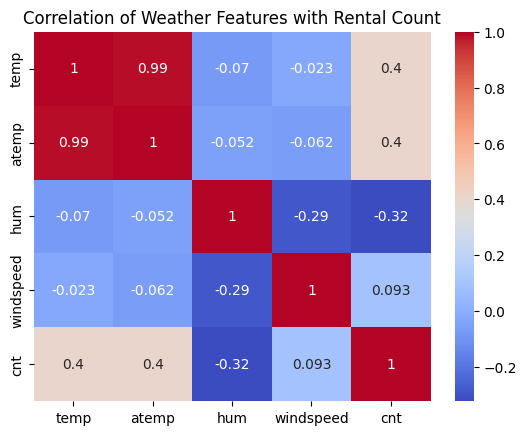

In [62]:
sns.heatmap(df[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation of Weather Features with Rental Count")
plt.show()

### Weather variables insights

I looked at how weather-related variables like temperature, humidity, and windspeed are correlated with bike rentals using a heatmap.

Both `temp` and `atemp` had a positive correlation of 0.4 with `cnt`, meaning that as temperature increases, bike rentals tend to increase too. Since these two variables are also almost perfectly correlated with each other (0.99), I’ll only keep one of them (most likely temp) to avoid multicollinearity.

`hum` had a moderate negative correlation of –0.32 with rentals, which makes sense because people may less inclined to rent a bike on very humid days. I’ll consider keeping this variable because it could help models make better predictions, especially tree-based ones.

Finally, `windspeed` had a very weak correlation with rental count. It doesn’t seem to have much influence, so I might drop it later depending on how it affects model performance.

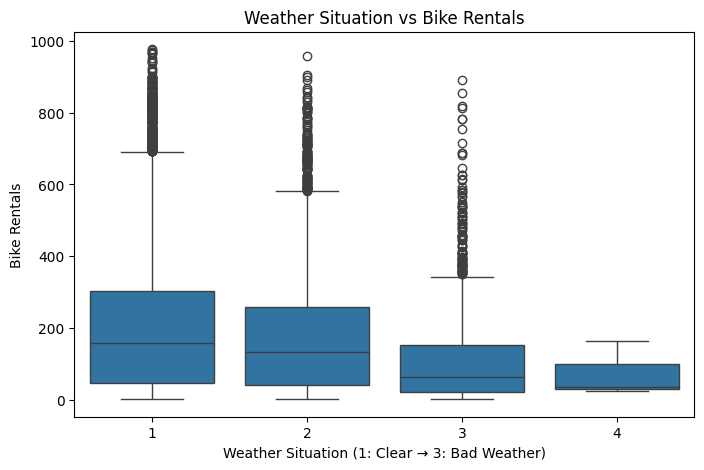

In [63]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='weathersit', y='cnt', data=df)
plt.title('Weather Situation vs Bike Rentals')
plt.xlabel('Weather Situation (1: Clear → 3: Bad Weather)')
plt.ylabel('Bike Rentals')
plt.show()

In [64]:
df['weathersit'].value_counts()

weathersit
1    11413
2     4544
3     1419
4        3
Name: count, dtype: int64

I used a boxplot to look at how `weathersit` affects bike rentals. The values go from 1 (clear or partly cloudy) to 4 (very bad weather). I noticed in the variables table in the assigment document it said 1-3 values for this variable so I was a bit confused on the 4, but then I got the counts for each value and noticed 4 only had 3 because only 3 people had rented biked in really bad weather.

As expected, the better the weather, the more people rent bikes. For `weathersit` = 1, the median and overall rentals are the highest, and they drop  as weather conditions get worse. For `weathersit` = 3 and especially 4, rentals are much lower.

This shows that `weathersit` has clear predictive power and should definitely be included in the model.

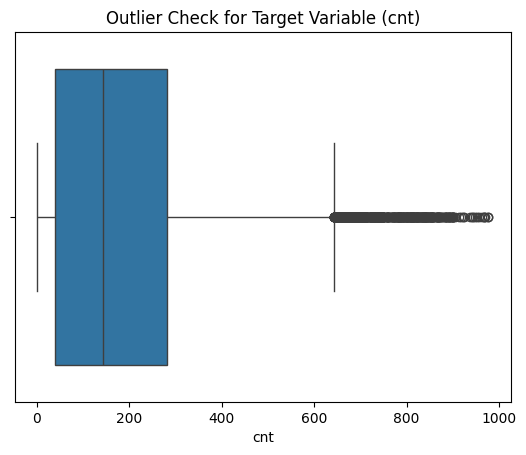

In [65]:
sns.boxplot(x=df['cnt'])
plt.title('Outlier Check for Target Variable (cnt)')
plt.show()

### Checking for outliers

I checked for outliers in the target variable  `cnt` using a boxplot. There are clearly a lot of high-value outliers, especially beyond 600 rentals per hour.

Since the data is from real-world usage, they could just reflect the peak demand hours in busy months or good weather, which is why I decided to keep the outliers for now instead of removing them. They could be important for model accuracy.

In [66]:
# Base dataset (drop the obvious ones)
df_cleaned = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

# For linear regression (drop more to avoid multicollinearity)
df_lr = df_cleaned.drop(['weekday', 'atemp', 'windspeed'], axis=1)

# For tree models (keep more as they can handle redundancy)
df_tree = df_cleaned.drop(['weekday'], axis=1)

I dropped the columns `instant` and `dteday` because they don’t provide useful or unique information for the model. We already have seen better time features than date, and ID doesn't provide meaningful information. In other words, they aren't predictive on their own.

I also dropped `casual` and `registered` because they directly add up to the target variable `cnt`. Including them would cause data leakage, since the model would be learning to predict a value it already partially knows.

I then created two separate versions of the dataset: one for Linear Regression, and one for tree-based models (Random Forest and Gradient Boosting), because they handle features differently.

For Linear Regression, I dropped:
- `atemp`, since it’s almost identical to `temp`, and multicollinearity would be a problem.
- `weekday`, because EDA showed almost no variation across the week.
- `windspeed`, since it had almost no correlation with `cnt`.

For tree models, I kept more features because these models can handle multicollinearity and irrelevant features better. I still dropped `weekday` because its predictive power was so weak that it wasn’t worth keeping. I chose to keep `atemp` and `windspeed` to see if they help the tree models during training.

## Task 2: Data Splitting

In [67]:
from sklearn.model_selection import train_test_split

# First split test sets
train_val_lr, test_lr = train_test_split(df_lr, test_size=0.2, random_state=42)
train_val_tree, test_tree = train_test_split(df_tree, test_size=0.2, random_state=42)

# Then split train/val from the remaining 80%
train_lr, val_lr = train_test_split(train_val_lr, test_size=0.25, random_state=42)
train_tree, val_tree = train_test_split(train_val_tree, test_size=0.25, random_state=42)

print("Linear Regression splits:")
print(f"Train: {train_lr.shape}, Validation: {val_lr.shape}, Test: {test_lr.shape}")
print("\nTree Model splits:")
print(f"Train: {train_tree.shape}, Validation: {val_tree.shape}, Test: {test_tree.shape}")

Linear Regression splits:
Train: (10427, 10), Validation: (3476, 10), Test: (3476, 10)

Tree Model splits:
Train: (10427, 12), Validation: (3476, 12), Test: (3476, 12)


I split my data into three sets: 60% for training, 20% for validation, and 20% for testing. This allows me to train the model, tune hyperparameters, and evaluate its performance fairly on unseen data. This random split ensures a balanced representation or distribution of different time periods in all sets. By doing this we also avoid training on one season and testing on another, which could hurt generalization.

I chose not to use a fully chronological split, as it could have led to seasonal bias in the training data. While temporal integrity is important, this assignment is not trying to solve a time-series forecasting problem.

I also made sure to apply the split before any feature engineering or scaling to avoid data leakage.

I created separate splits for the two versions of my dataset:
- One for Linear Regression,
- Another for the tree-based models.

If needed, I could experiment with a "rolling anchor" approach, selecting different starting points for the split to balance both variability and temporal structure.

## Task 3: Feature Engineering

In [68]:
df['weathersit'] = df['weathersit'].replace(4, 3)

df_lr['commute_hour'] = ((df_lr['workingday'] == 1) & (df_lr['hr'].isin([7,8,17,18]))).astype(int)

df_lr['hr_sin'] = np.sin(2 * np.pi * df_lr['hr'] / 24)
df_lr['hr_cos'] = np.cos(2 * np.pi * df_lr['hr'] / 24)

df_lr = df_lr.drop('hr', axis=1)

In the EDA, I noticed that when `weathersit = 4` occurred only a few times in the dataset(3 in total). Since this level represents extreme or rare weather conditions, it had too few samples to provide meaningful learning, and it risked overfitting the model. To avoid this, I decided to merge it with `weathersit = 3`, creating a more stable and broader group when there is bad weather.

I also engineered the `commute_hour` feature after analyzing temporal variables in EDA. It captures the spike in bike rentals during commuting hours: 7–8 AM and 5–6 PM on working days. This helps, especially the linear regression model, learn this interaction.

I applied cyclical encoding to the `hr` feature because it represents time of day, which is cyclical. Like hour 23 and hour 0 are right next to each other in reality, but if we use the actual numbers with no encoding the model will treat them as far apart. To fix this, I used sine and cosine transforms to map the hours as a circle. 

After applying cyclical encoding to the `hr` feature, I dropped the original `hr` column because keeping the raw values would confuse the model.



In [69]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['season', 'weathersit', 'mnth']

# Separate X and y
X_train_lr = train_lr.drop('cnt', axis=1)
y_train_lr = train_lr['cnt']

X_val_lr = val_lr.drop('cnt', axis=1)
y_val_lr = val_lr['cnt']

X_test_lr = test_lr.drop('cnt', axis=1)
y_test_lr = test_lr['cnt']

# One-hot encode only on training set
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train_lr[categorical_cols])

X_train_encoded = encoder.transform(X_train_lr[categorical_cols])
X_val_encoded = encoder.transform(X_val_lr[categorical_cols])
X_test_encoded = encoder.transform(X_test_lr[categorical_cols])

# Drop original categorical columns
X_train_lr = X_train_lr.drop(columns=categorical_cols)
X_val_lr = X_val_lr.drop(columns=categorical_cols)
X_test_lr = X_test_lr.drop(columns=categorical_cols)

# Convert encoded arrays into DataFrames with proper column names
encoded_col_names = encoder.get_feature_names_out(categorical_cols)

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_col_names, index=X_train_lr.index)
X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=encoded_col_names, index=X_val_lr.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_col_names, index=X_test_lr.index)

# Concatenate with remaining features
X_train_lr = pd.concat([X_train_lr, X_train_encoded_df], axis=1)
X_val_lr = pd.concat([X_val_lr, X_val_encoded_df], axis=1)
X_test_lr = pd.concat([X_test_lr, X_test_encoded_df], axis=1)

/Users/dianacordovez/venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/dianacordovez/venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


I did one-hot encoding only after splitting the dataset. I fit the `OneHotEncoder` on the training set and applied the transformation to the validation and test sets to avoid data leakage.This transformation was applied to the categorical variables `season`, `weathersit`, and `mnth`. I used `drop='first'` to prevent multicollinearity, and `handle_unknown='ignore'` to avoid facing issues with unseen categories.

I also want to mention that I'm only applying encoding both cyclical and one-hot to the linear regression dataframe because tree-based models can handle categorical variables in their original form. This also avoids increasing dimensionality, which could actually reduce performance.

In [70]:
print(X_train_lr.columns)


Index(['yr', 'hr', 'holiday', 'workingday', 'temp', 'hum', 'season_2',
       'season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12'],
      dtype='object')


In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_lr[['temp', 'hum']] = scaler.fit_transform(X_train_lr[['temp', 'hum']])
X_val_lr[['temp', 'hum']] = scaler.transform(X_val_lr[['temp', 'hum']])
X_test_lr[['temp', 'hum']] = scaler.transform(X_test_lr[['temp', 'hum']])

I applied feature scaling using StandardScaler to the continuous variables `temp` and `hum` for the linear regression model only. I selected these because of their relevance to `cnt` and from what we saw in the EDA.

Scaling was done after splitting the data to avoid data leakage. The scaler was fit only on the training set, and transformation from train was applied to the validation and test sets.

I excluded `windspeed` and `atemp` from scaling because they weren't included in the final version of the linear regression dataset. I just thought that it was wise to drop them due to their low correlation with the target and minimal impact during EDA.

Also, like in encoding, tree-based models do not require feature scaling, so I didn't apply scaling was applied to the dataset used for tree models.

## Task 4: Linear Regression

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

y_val_pred_lr = lr_model.predict(X_val_lr)

mse = mean_squared_error(y_val_lr, y_val_pred_lr)
mae = mean_absolute_error(y_val_lr, y_val_pred_lr)
r2 = r2_score(y_val_lr, y_val_pred_lr)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


MSE: 19087.83
MAE: 104.18
R² Score: 0.4130


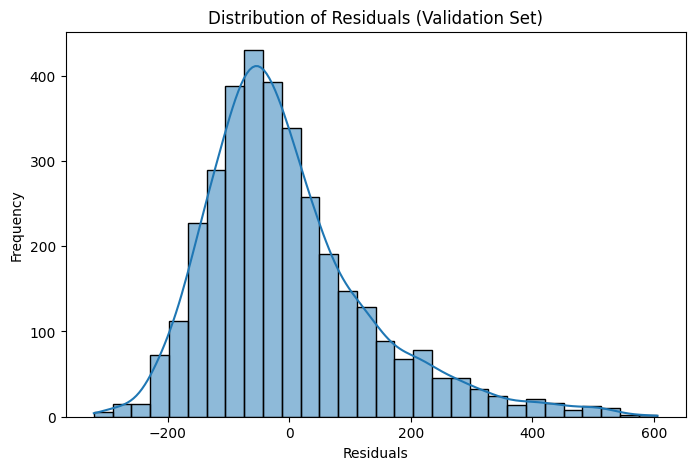

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_val_lr - y_val_pred_lr

plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribution of Residuals (Validation Set)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

As the baseline, I started training a linear regression. So the model got:
- An MSE of ~19,088, meaning there's a high average prediction error specially when rental counts are high. 
- MAE of ~104, meaning that on average the model is off by 104 rentals per hour. That's a pretty high number considering `cnt` usually ranges from 50 to 500+.
- The R² score of 0.41 also confirms that the model explains just a portion of the variability in the data.

Looking at the residuals plot,we can tell that they’re mostly normally distributed and centered around zero, which is expected. However, there’s a slight skew to the right, meaning the model tends to underpredict high bike rental counts. This shows consistency with the long tail in the target distribution we saw earlier in the EDA.

Overall, the linear model shows signs of underfitting and has high bias, which makes sense given how simple it is. Good as a baseline, but I think it's time we train the other models.

## Task 5: Random Forest Regressor

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train_tree = train_tree.drop('cnt', axis=1)
y_train_tree = train_tree['cnt']
X_val_tree = val_tree.drop('cnt', axis=1)
y_val_tree = val_tree['cnt']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_tree, y_train_tree)

y_val_pred_rf = rf_model.predict(X_val_tree)

mse_rf = mean_squared_error(y_val_tree, y_val_pred_rf)
mae_rf = mean_absolute_error(y_val_tree, y_val_pred_rf)
r2_rf = r2_score(y_val_tree, y_val_pred_rf)

print(f"MSE (RF): {mse_rf:.2f}")
print(f"MAE (RF): {mae_rf:.2f}")
print(f"R² Score (RF): {r2_rf:.4f}")

MSE (RF): 2124.45
MAE (RF): 28.68
R² Score (RF): 0.9347


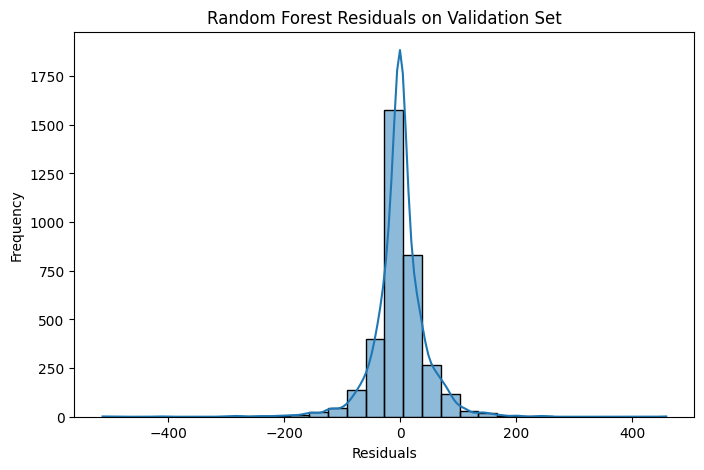

In [75]:
residuals_rf = y_val_tree - y_val_pred_rf

plt.figure(figsize=(8, 5))
sns.histplot(residuals_rf, kde=True, bins=30)
plt.title("Random Forest Residuals on Validation Set")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

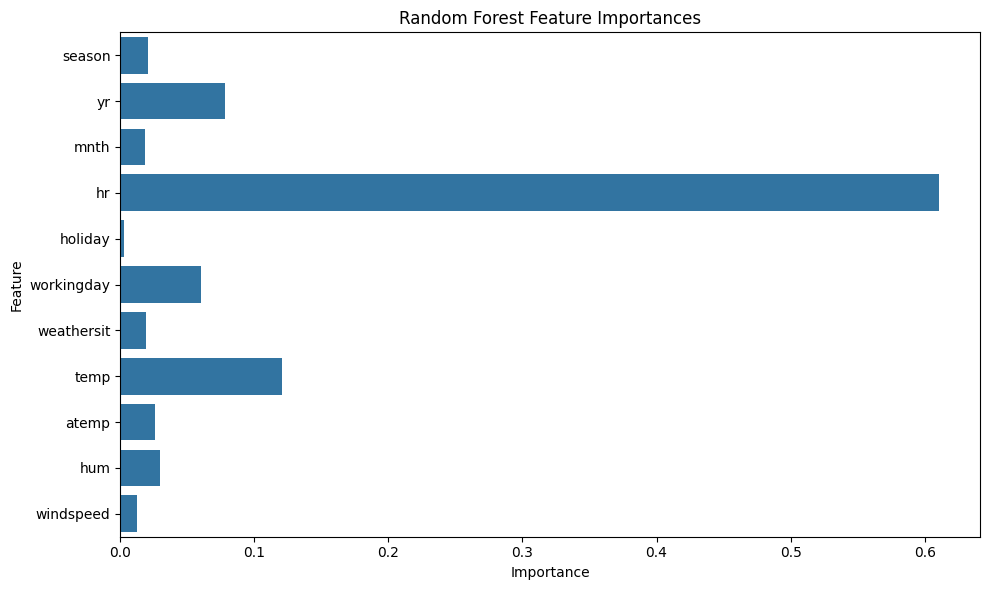

In [76]:
importances = rf_model.feature_importances_
feature_names = X_train_tree.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

I trained a Random Forest Regressor using 100 estimators and default parameters to establish a baseline for tree-based models.

Performance:

On the validation set, the model achieved:
- MSE: 2124.45
- MAE: 28.68
- R²: 0.9347

These results show a significant improvement over the baseline Linear Regression model. This proves that the Random Forest is able to capture nonlinear relationships and complex feature interactions much better and without needing to encode or scale features.

Residuals Analysis:
- The residuals distribution is more centered around zero and symmetric compared to Linear Regression, which confirms that this model is less biased and fits the data more effectively. There also seems to be fewer large outliers. This tell us that predictions were mostly and consistenlty close to the actual values across a wide range of conditions, pointing to a lower variance.

Feature Importance:
- The feature importance plot shows that `hr` was by far the most important predictor, contributing more than 60% to the model’s predictive power. This aligns with the EDA insights, where we saw strong rental patterns based on time of day, commute hours for example.

- The next most important features were `temp`, `yr`, and `workingday`. This also makes sense because usually bike rentals tend to increase in warmer weather, and also the dataset shows overall growth in rentals from 2011 to 2012.

- Features like `holiday`, `humidity`, and `windspeed` had much lower importance scores, meaning the model didn’t find them as helpful for making decisions. These may still have minor effects, but they don’t motivate the model’s predictions.

Comparison:
- In Linear Regression importance is tied to the coefficient magnitude (assuming linear relationships). On the other hand, Random Forest captures nonlinear interactions and more complex decision boundaries. It's key to reflect on such feature importances because they present a deeper signal, not just direct correlation. They also help confirm our earlier feature selection choices, where we retained variables like `hr`, `temp`, and `workingday` based on their predictive patterns during EDA.

## Task 6: Gradient Boosting Regressor

MSE (GBR): 4626.57
MAE (GBR): 46.52
R² Score (GBR): 0.8577


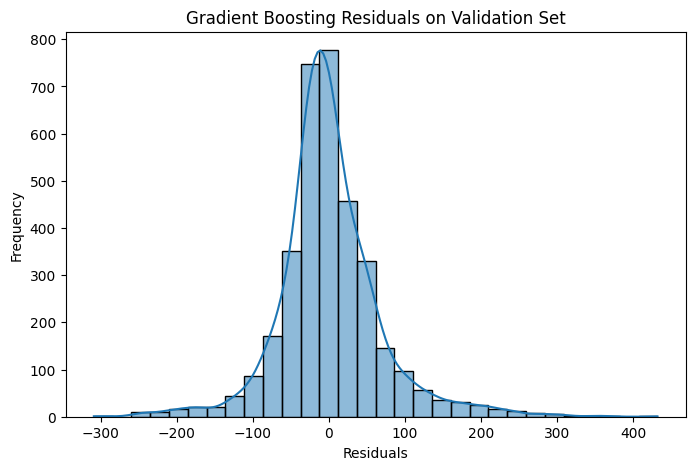

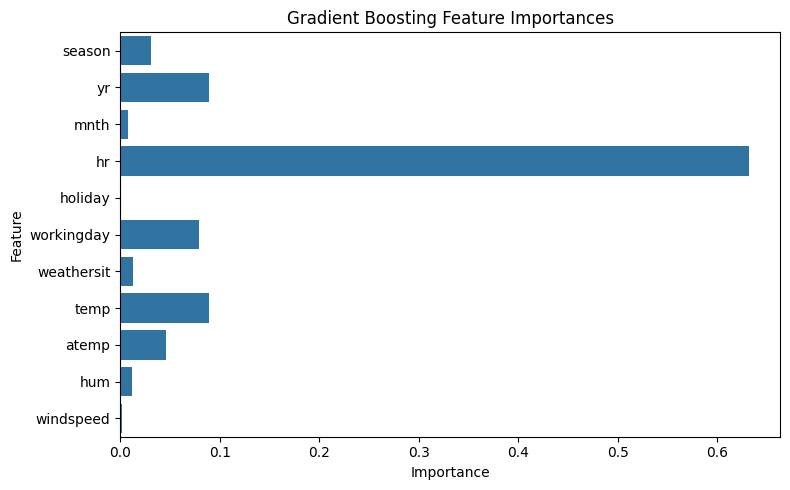

In [77]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Train the Gradient Boosting model
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train_tree, y_train_tree)

# 2. Predict on validation set
y_val_pred_gbr = gbr_model.predict(X_val_tree)

# 3. Evaluate the model
mse_gbr = mean_squared_error(y_val_tree, y_val_pred_gbr)
mae_gbr = mean_absolute_error(y_val_tree, y_val_pred_gbr)
r2_gbr = r2_score(y_val_tree, y_val_pred_gbr)

print(f"MSE (GBR): {mse_gbr:.2f}")
print(f"MAE (GBR): {mae_gbr:.2f}")
print(f"R² Score (GBR): {r2_gbr:.4f}")

# 4. Plot residuals
residuals_gbr = y_val_tree - y_val_pred_gbr

plt.figure(figsize=(8, 5))
sns.histplot(residuals_gbr, kde=True, bins=30)
plt.title("Gradient Boosting Residuals on Validation Set")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# 5. Optional: Feature Importances
importances = gbr_model.feature_importances_
feature_names = X_train_tree.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Gradient Boosting Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The Gradient Boosting Regressor showed good performance, with performance metrics that clearly improved over the linear regression baseline model.

Performance Metrics:

- MSE: 4626.57
- MAE: 46.52
- R² Score: 0.8577

Compared to linear regression (R² = ~0.41) and Random Forest (R² ≈ 0.93), the GBR sits between the two, but closer to the Random Forest. The R² score of 0.8577 suggests that over 85% of the variance in the bike rental counts is being explained by the model. The MSE and MAE are significantly lower than in the linear regression, showing predictions are closer to the actual values and also large errors are much less frequent.

Residual Analysis and Comparison:
- Both Random Forest and Gradient Boosting performed significantly better than the baseline Linear Regression model. However, when comparing the two tree-based models, I noticed some key differences in their behavior.

- Even though the Gradient Boosting Regressor had a strong R² score (0.8577), it actually showed wider residuals on the validation set. So while its predictions were generally accurate, there was more variability in how far off some of them were. Basically the errors were more spread out.

- In contrast, the Random Forest Regressor had residuals that were more tightly centered around zero, which suggests it made more consistent and stable predictions. This was also reflected in its lower Mean Absolute Error (28.68) compared to Gradient Boosting's (46.52).

- So overall, Random Forest not only had strong performance metrics but also less prediction variance than Gradient Boosting in this case, which makes it the more reliable model based on my current setup.

- Feature Importance:
The feature importance chart reveals that `hr` is by far the most influential predictor, again proving consistency with the EDA and the Random Forest results.

Other relevant predictors include:

`temp`: Weather still has a strong effect because people ride more when it’s warmer.

`workingday` and `yr`: Both remain fairly important, confirming consistent behavioral patterns depending on weekday vs. weekend and long-term growth over the years.

`atemp`, `hum`, and `windspeed` show moderate to low influence, still contributing but not as critical.

`mnth`, `season`, and `weathersit` carry low importance, aligning with the idea that while seasonality matters, hour-level and environmental features are more predictive.

Overfitting or Variance Concerns:
There is no strong indication of overfitting at this stage. The validation residuals are not noisy or overly spread, and the R² isn’t suspiciously high.

## Task 7: Hyperparameter Tuning

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Parameter grid
param_dist_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_base = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf_base, param_distributions=param_dist_rf,
                               n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

rf_random.fit(X_train_tree, y_train_tree)

print("Best parameters for RF:", rf_random.best_params_)

Best parameters for RF: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


Tuned RF - MSE: 2118.58
Tuned RF - MAE: 28.67
Tuned RF - R² Score: 0.9348


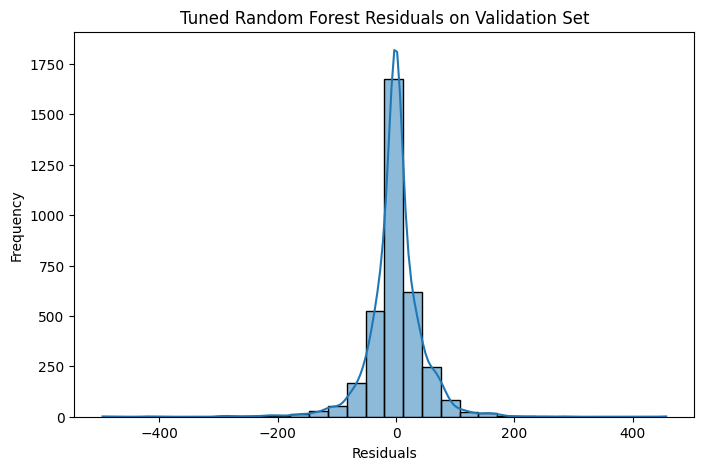

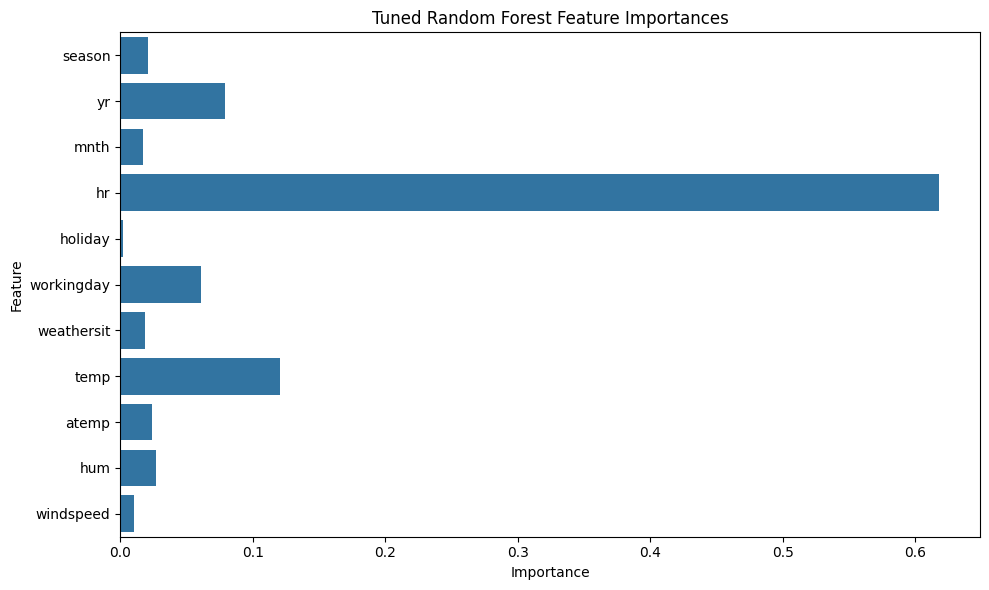

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on validation set using best RF model
y_val_pred_rf_tuned = rf_random.predict(X_val_tree)

# Evaluate performance
mse_rf_tuned = mean_squared_error(y_val_tree, y_val_pred_rf_tuned)
mae_rf_tuned = mean_absolute_error(y_val_tree, y_val_pred_rf_tuned)
r2_rf_tuned = r2_score(y_val_tree, y_val_pred_rf_tuned)

print(f"Tuned RF - MSE: {mse_rf_tuned:.2f}")
print(f"Tuned RF - MAE: {mae_rf_tuned:.2f}")
print(f"Tuned RF - R² Score: {r2_rf_tuned:.4f}")

# Residual plot
residuals_rf_tuned = y_val_tree - y_val_pred_rf_tuned

plt.figure(figsize=(8,5))
sns.histplot(residuals_rf_tuned, kde=True, bins=30)
plt.title("Tuned Random Forest Residuals on Validation Set")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Feature importance
importances_tuned_rf = rf_random.best_estimator_.feature_importances_
features_rf = X_train_tree.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances_tuned_rf, y=features_rf)
plt.title("Tuned Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Random Forest (After Tuning)
After tuning the Random Forest Regressor using RandomizedSearchCV with 5-fold cross-validation, the best parameters found were:

- n_estimators = 200
- min_samples_split = 2
- min_samples_leaf = 2
- max_depth = None

I selected these hyperparameters based on minimizing the validation MSE during the search. The MSE reflects generalization and heavily penalizes large errors, which is why I wanted to optimize it.

Performance:

- MSE: 2118.58 (vs. 2124.45 before tuning)
- MAE: 28.67 (vs. 28.68 before tuning)
- R²: 0.9348 (vs. 0.9347 before tuning)

The performance only improved very slightly, but given that it already had performed well and it is a tree-based model, I would say this is a doog improvement. It suggests that the model was already close to optimal, and there's not much overfitting or underfitting going on.

Residuals Plot: 
- The residual distribution looks basically the same: very concentrated around zero, meaning predictions are accurate most of the time. The variance didn’t change much either, which again points to stability.

Feature Importance: 
- The feature importance ranking didn’t shift dramatically after tuning. `hr` is still by far the most influential variable, followed by `temp`, `yr`, and `workingday. This reinforces the insight that time of day and temperature are key predictors of bike demand, and tuning didn’t drastically change the model’s behavior in that regard.

In [80]:
from skopt import BayesSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from skopt.space import Real, Integer

param_space_gbr = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 10),
    'subsample': Real(0.6, 1.0)
}

gbr_base = GradientBoostingRegressor(random_state=42)
gbr_bayes = BayesSearchCV(gbr_base, param_space_gbr, n_iter=30, cv=5,
                          scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

gbr_bayes.fit(X_train_tree, y_train_tree)

print("Best parameters for GBR:", gbr_bayes.best_params_)

Best parameters for GBR: OrderedDict({'learning_rate': 0.040343472274915984, 'max_depth': 8, 'n_estimators': 283, 'subsample': 0.7263198373948194})


In [83]:
gbr_tuned = GradientBoostingRegressor(
    learning_rate=0.0403,
    max_depth=8,
    n_estimators=283,
    subsample=0.726,
    random_state=42
)

gbr_tuned.fit(X_train_tree, y_train_tree)
y_val_pred_gbr = gbr_tuned.predict(X_val_tree)

# Evaluate
mse_gbr = mean_squared_error(y_val_tree, y_val_pred_gbr)
mae_gbr = mean_absolute_error(y_val_tree, y_val_pred_gbr)
r2_gbr = r2_score(y_val_tree, y_val_pred_gbr)

print(f"Tuned GBR – MSE: {mse_gbr:.2f}")
print(f"Tuned GBR – MAE: {mae_gbr:.2f}")
print(f"Tuned GBR – R² Score: {r2_gbr:.4f}")

Tuned GBR – MSE: 1799.07
Tuned GBR – MAE: 26.44
Tuned GBR – R² Score: 0.9447


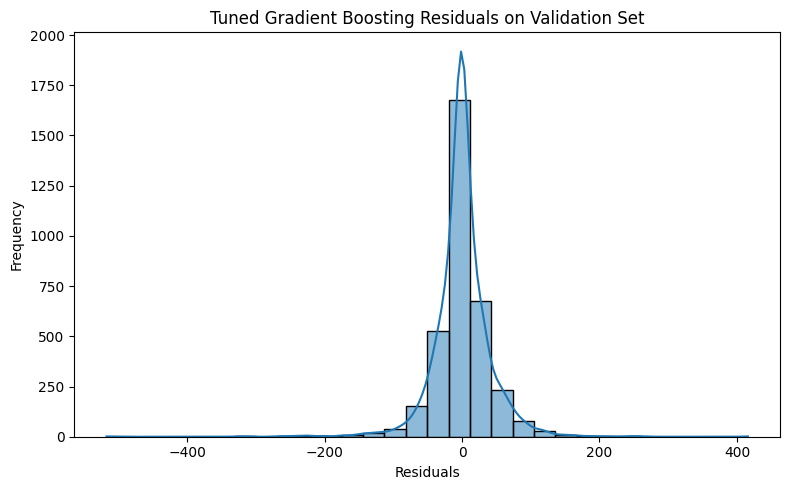

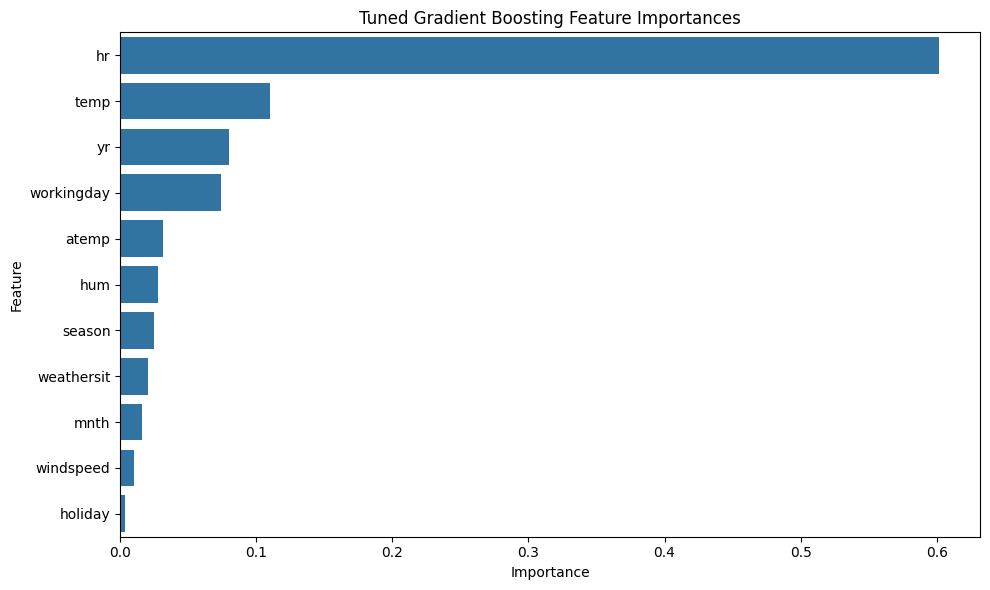

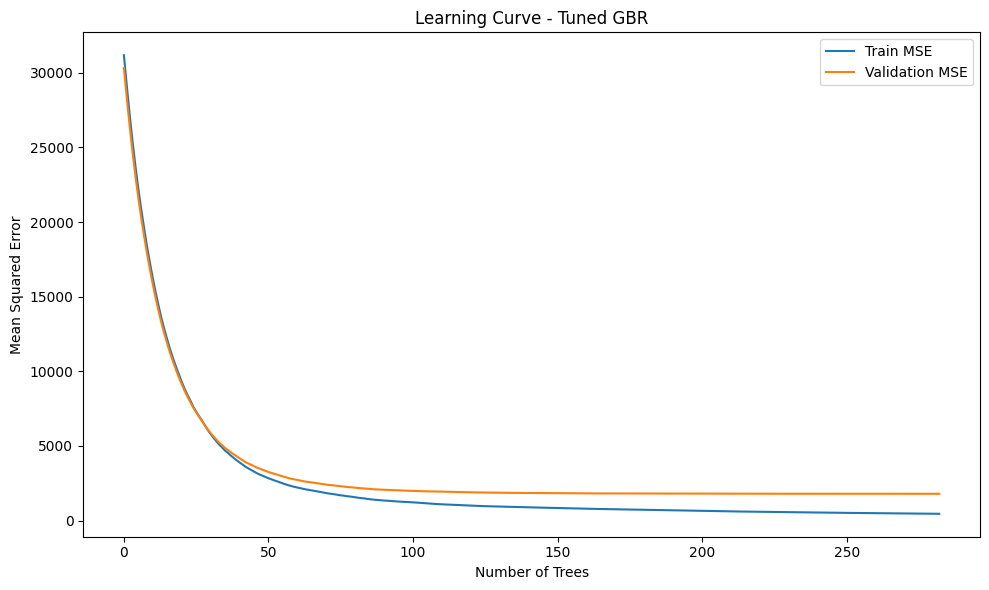

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error

residuals_gbr = y_val_tree - y_val_pred_gbr

plt.figure(figsize=(8, 5))
sns.histplot(residuals_gbr, kde=True, bins=30)
plt.title("Tuned Gradient Boosting Residuals on Validation Set")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

importances = gbr_tuned.feature_importances_
feature_names = X_train_tree.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Tuned Gradient Boosting Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

train_errors = []
val_errors = []

# staged_predict gives predictions at each stage of boosting
for y_pred_train, y_pred_val in zip(
    gbr_tuned.staged_predict(X_train_tree), 
    gbr_tuned.staged_predict(X_val_tree)
):
    train_errors.append(mean_squared_error(y_train_tree, y_pred_train))
    val_errors.append(mean_squared_error(y_val_tree, y_pred_val))

plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train MSE')
plt.plot(val_errors, label='Validation MSE')
plt.xlabel("Number of Trees")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve - Tuned GBR")
plt.legend()
plt.tight_layout()
plt.show()

I used Bayesian Optimization via `BayesSearchCV` to tune the hyperparameters of the Gradient Boosting Regressor. The optimizer explored combinations efficiently and returned the following:

- learning_rate: 0.0403
- n_estimators: 283
- max_depth: 8
- subsample: 0.726

These parameters aim to bring a balance between model complexity and generalization. A low learning rate combined with a pretty high number of estimators and deeper trees allows the model to learn in smaller, more refined steps which helping avoid overfitting.

Performance (Tuned Gradient Boosting Regressor):

- MSE: 1799.07 (vs. 4626.57 before tuning)
- MAE: 26.44 (vs. 46.52 before tuning)
- R²: 0.9447 (vs. 0.8577 before tuning)

After tuning the Gradient Boosting Regressor using Bayesian optimization, the model showed a clear improvement across all the performance metrics.

Residuals plot:
- The residual plot shows a very tight, symmetric distribution centered around zero, which is exactly what we want. This tells us the errors are small and balanced and we're not consistently over- or under-predicting.

Feature Importance:
- The feature importance plot confirms that `hr` is still by far the most important feature, followed by `temp`, `yr`, and `workingday`.

Lastly, I also plotted the learning curves which in this case gives me more confidence in the model.  Both training and validation errors steadily decrease and level off as the number of trees increases, and the gap between them stays small. This shows the model is learning well and is not overfitting.

Overall, tuning significantly improved the model’s performance and stability. The final tuned GBR model is not only accurate but also shows no signs of overfitting, making it a strong candidate for deployment or further experimentation.

## Task 8: Iterative Evaluation and Refinement

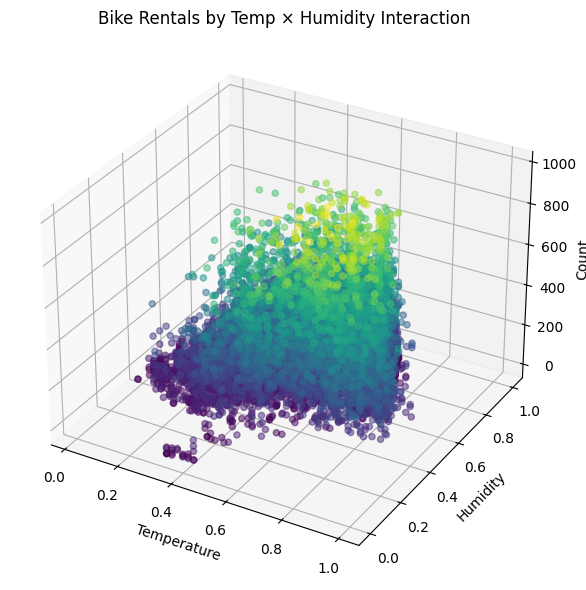

In [85]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['temp'], df['hum'], df['cnt'], alpha=0.5, c=df['cnt'], cmap='viridis')
ax.set_xlabel('Temperature')
ax.set_ylabel('Humidity')
ax.set_zlabel('Count')
ax.set_title('Bike Rentals by Temp × Humidity Interaction')
plt.tight_layout()
plt.show()

I created a 3D scatter plot to explore whether the combination of temperature and humidity affects bike rental counts in a meaningful way.

The plot shows that higher bike rental counts generally happen when temperature is high and humidity is moderate. There’s an upward trend in rentals with rising temperatures, but it flattens or drops off slightly when humidity goes up.

However if we recall back to the EDA where I plotted a heatmap of the features, it showed that humidity has a fairly weak negative correlation with rental counts (−0.32), while temperature (both `temp` and `atemp`) had much stronger positive relationships. So while there may be a powerful interaction there, I feel like it wouldnt significantly improve the model which is why I'm not including it.

After evaluating the performance of all three models, and especially after hyperparameter tuning, I found that the Tuned Gradient Boosting Regressor (GBR) performed the best overall. Its validation metrics clearly improved compared to both the baseline and the tuned Random Forest, and the learning curve seemed to have a smooth convergence without overfitting.

Because of this strong performance:

- I decided not to add interaction terms, as the current setup already captures the underlying patterns well.
- There were no obvious signs of outliers or poor predictors based on the residual plots, which were symmetrical and centered around 0.
- The model complexity seems well-balanced (the validation error didn’t increase with more trees and the gap between training and validation MSE was small).

So, for now I didn’t retrain or make more adjustments.
But I’d consider additional refinements if I saw issues like:

- High variance between train and validation,
- Unstable residuals,
- Or certain predictors dominating with little interpretability.

## Task 9: Final Model Selection and Testing

In [87]:
X_test_tree = test_tree.drop('cnt', axis=1)
y_test_tree = test_tree['cnt']

In [88]:
X_full = pd.concat([X_train_tree, X_val_tree])
y_full = pd.concat([y_train_tree, y_val_tree])

gbr_final = GradientBoostingRegressor(
    learning_rate=0.0403,
    max_depth=8,
    n_estimators=283,
    subsample=0.726,
    random_state=42
)
gbr_final.fit(X_full, y_full)

y_test_pred = gbr_final.predict(X_test_tree)

mse_test = mean_squared_error(y_test_tree, y_test_pred)
mae_test = mean_absolute_error(y_test_tree, y_test_pred)
r2_test = r2_score(y_test_tree, y_test_pred)

print(f"Test MSE: {mse_test:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Test R²: {r2_test:.4f}")

Test MSE: 1747.03
Test MAE: 25.89
Test R²: 0.9448


Performance on the test set:

MSE: 1747.03
- This is the Mean Squared Error, which penalizes large errors more than small ones. A lower MSE here suggests that the model is making small, consistent errors on average. There are no big outliers throwing it off, which is good.

MAE: 25.89
- The Mean Absolute Error tells us the average difference between our predictions and the actual bike rental counts. On average, our predictions are off by 26 rentals, which is not bad and pretty practical for decision-making.

R²: 0.9448
- This just means that around 94.5% of the variance in bike rental counts is explained by the model. I think that’s really strong, specially given the fact that this score (seen on val) held even when using unseen data which is exactly what we want.

Why the model generalizes well?
Low Bias:
- The high R² score and low errors on both the validation and test sets suggest the model captures the underlying data patterns well.

Low Variance:
There’s no major drop in performance when we move from validation to test:

- Validation R² was 0.9447, and test R² is 0.9448.

MSE and MAE also remained around the same. This shows the model isn’t overfitting. It’s stable and adaptable, which is crucial to generalize.

Bias/Variance tradeoffs:
Gradient Boosting often tends to lean toward low bias but higher variance. But because we did hyperparameter tuning carefully for our modelm(like reducing learning_rate, increasing n_estimators, and setting a reasonable max_depth), we balanced that out:

- We gave the model enough complexity to learn the relationships and interactions well,
- While also using parameters like `subsample` to insert some randomness and prevent overfitting.